This notebook will input and explore our data, prepare it for modeling, and run it through two key classification models to predict damage levels. Ultimately, we found that KNN was our best model. This will be teased out and discussed as we move through the notebook. 

In [ ]:
# Math and Data Reading
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
values = pd.read_csv('/content/drive/MyDrive/train_values.csv')
labels = pd.read_csv('/content/drive/MyDrive/train_labels.csv')
test_values = pd.read_csv('/content/drive/MyDrive/test_labels.csv')

In [ ]:
df_eq = pd.merge(left = values, right = labels, left_on = values['building_id'], right_on = labels['building_id'] )

In [ ]:
df_eq.head(3)

,key_0,building_id_x,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,...,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,building_id_y,damage_grade
0,802906,802906,6,487,12198,2,30,6,5,t,...,0,0,0,0,0,0,0,0,802906,3
1,28830,28830,8,900,2812,2,10,8,7,o,...,0,0,0,0,0,0,0,0,28830,2
2,94947,94947,21,363,8973,2,10,5,5,t,...,0,0,0,0,0,0,0,0,94947,3


In [ ]:
df_eq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 42 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   key_0                                   260601 non-null  int64 
 1   building_id_x                           260601 non-null  int64 
 2   geo_level_1_id                          260601 non-null  int64 
 3   geo_level_2_id                          260601 non-null  int64 
 4   geo_level_3_id                          260601 non-null  int64 
 5   count_floors_pre_eq                     260601 non-null  int64 
 6   age                                     260601 non-null  int64 
 7   area_percentage                         260601 non-null  int64 
 8   height_percentage                       260601 non-null  int64 
 9   land_surface_condition                  260601 non-null  object
 10  foundation_type                         260601 non-null 

In [ ]:
df_eq.isnull().sum()

key_0                                     0
building_id_x                             0
geo_level_1_id                            0
geo_level_2_id                            0
geo_level_3_id                            0
count_floors_pre_eq                       0
age                                       0
area_percentage                           0
height_percentage                         0
land_surface_condition                    0
foundation_type                           0
roof_type                                 0
ground_floor_type                         0
other_floor_type                          0
position                                  0
plan_configuration                        0
has_superstructure_adobe_mud              0
has_superstructure_mud_mortar_stone       0
has_superstructure_stone_flag             0
has_superstructure_cement_mortar_stone    0
has_superstructure_mud_mortar_brick       0
has_superstructure_cement_mortar_brick    0
has_superstructure_timber       

The dataset has no null values, and the dtypes coincide correctly with the feature names. By merging the train and target datasets for easier splitting, new columns for building_id were created. We removed these below.

In [ ]:
df_eq.drop(columns = ['building_id_x', 'building_id_y'], inplace=True)

In [ ]:
label_key = df_eq['key_0']  # if we need it later, it's here!

In [ ]:
df_eq.drop(columns = ['key_0'], inplace=True)

In [ ]:
df_eq.head(3)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3
1,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,2
2,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,3


In [ ]:
X = df_eq.drop(columns = ['damage_grade'])
y = df_eq['damage_grade']

In [ ]:
# df_eq[['damage_grade']].to_csv('/content/drive/MyDrive/damage_grade_target.csv', index=True) saved y as a csv to load into tableau

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=13, stratify=y) #removed stratify in order for the code to work - discuss with group

In [ ]:
X.head(3)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
1,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,0
2,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 38 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-null 

In [ ]:
X.describe()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
count,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,...,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,0.034332,...,0.064378,0.033626,0.008101,0.000940,0.000361,0.001071,0.000188,0.000146,0.000088,0.005119
std,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,0.182081,...,0.245426,0.180265,0.089638,0.030647,0.018989,0.032703,0.013711,0.012075,0.009394,0.071364
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


From the descriptive statistics above, I can see that the numbers generally match with the feature definition. Because we are talking about buildings and not people, the age category doesn't stand out as suspicious. It looks like the average age is 26 years old, but the maxmimum is 995 years old. That is a ver broad distribution. Because most of the features are binary, there is not much else here to look into. 

Next, we will look at a few introductory visualizations (all visualizations can be found in our EDA-visualizations file) before moving on to modeling.

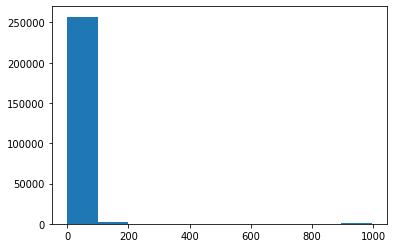

In [ ]:
plt.hist(X['age']);

# Can see that broad distribution of age that we noted above

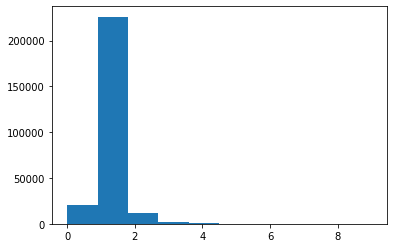

In [ ]:
plt.hist(X['count_families']);

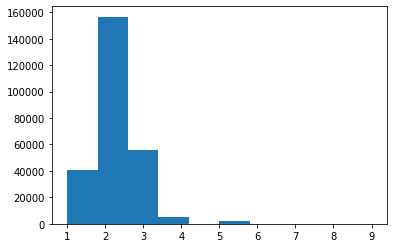

In [ ]:
plt.hist(X['count_floors_pre_eq']);

# it looks like most of our main numeric features are skewed right

In [ ]:
fig = make_subplots(rows=1, cols=3, subplot_titles=['Geo Level 1', 'Geo Level 2', 'Geo Level 3'])

fig.add_trace(go.Histogram(x=X['geo_level_1_id']), 1, 1)

fig.add_trace(go.Histogram(x=X['geo_level_2_id']), 1, 2)

fig.add_trace(go.Histogram(x=X['geo_level_3_id']), 1, 3)

fig.update_layout(showlegend=False)

fig.show()

Will need to find out what Geo Level Id means, but for now - it looks like there are significantly more in Geo Level 1 than in either of the other Geo Levels. We can see also from the quick histograms above this that majority of the buildings in this dataset are more recently built, have a small number of floors, and have mostly 0-2 families living in them. It will be interesting to see how the amount of damage lines up with some of these categories. Next, I want to explore the different types of structures and the age of the buildings compared to other features. 

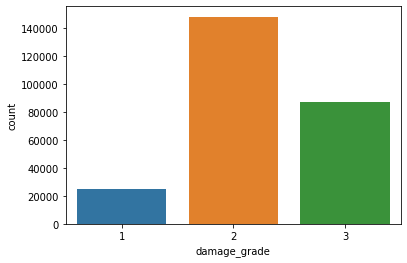

In [ ]:
sns.countplot(data=df_eq, x='damage_grade');

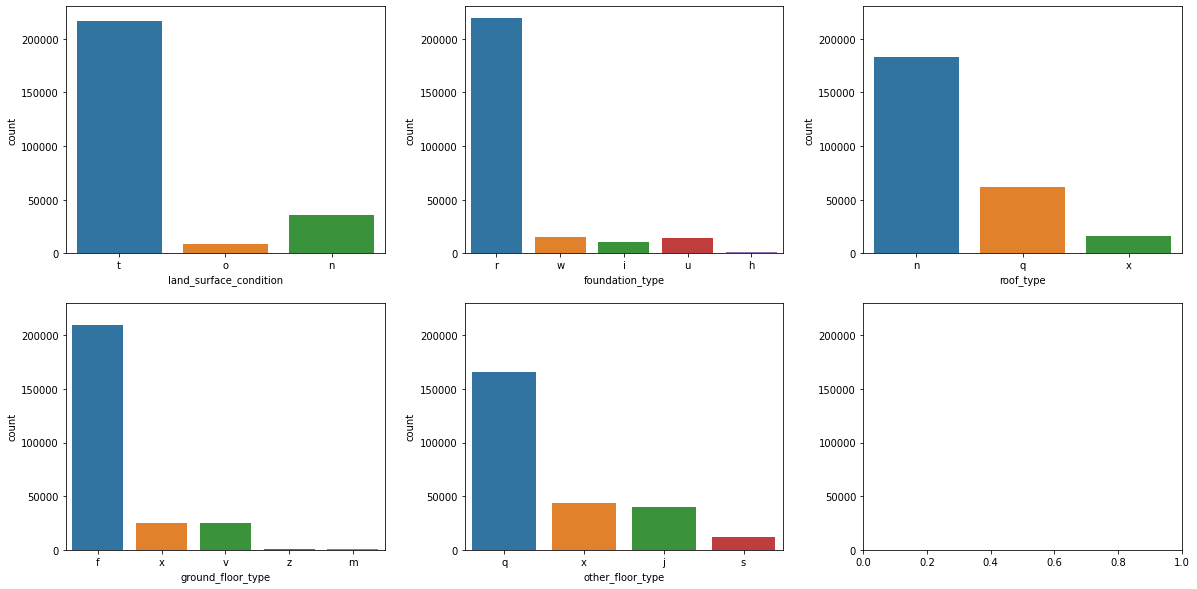

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
fig.subplots_adjust(wspace=0.25)
sns.countplot(ax=axes[0, 0], data=X, x='land_surface_condition')
sns.countplot(ax=axes[0, 1], data=X, x='foundation_type')
sns.countplot(ax=axes[0, 2], data=X, x='roof_type')
sns.countplot(ax=axes[1, 0], data=X, x='ground_floor_type')
sns.countplot(ax=axes[1, 1], data=X, x='other_floor_type')
plt.setp(axes, ylim=axes[0,1].get_ylim());

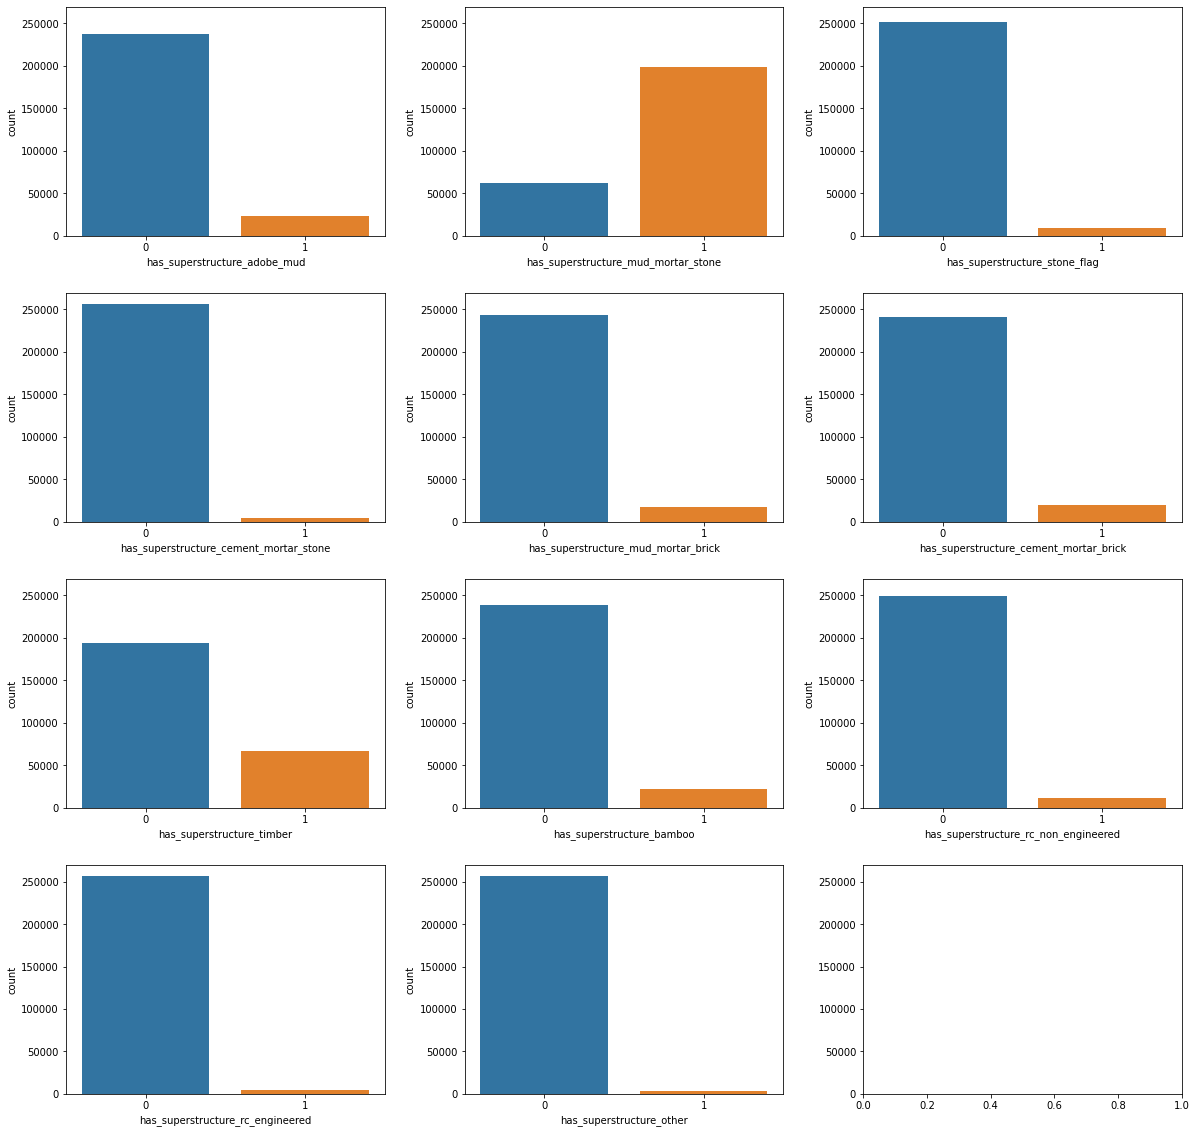

In [ ]:
#superstructure characteristics

fig, axes = plt.subplots(4, 3, figsize=(20, 20))
fig.subplots_adjust(wspace=0.25)
fig.subplots_adjust(hspace=0.25)
sns.countplot(ax=axes[0, 0], data=X, x='has_superstructure_adobe_mud')
sns.countplot(ax=axes[0, 1], data=X, x='has_superstructure_mud_mortar_stone')
sns.countplot(ax=axes[0, 2], data=X, x='has_superstructure_stone_flag')
sns.countplot(ax=axes[1, 0], data=X, x='has_superstructure_cement_mortar_stone')
sns.countplot(ax=axes[1, 1], data=X, x='has_superstructure_mud_mortar_brick')
sns.countplot(ax=axes[1, 2], data=X, x='has_superstructure_cement_mortar_brick')
sns.countplot(ax=axes[2, 0], data=X, x='has_superstructure_timber')
sns.countplot(ax=axes[2, 1], data=X, x='has_superstructure_bamboo')
sns.countplot(ax=axes[2, 2], data=X, x='has_superstructure_rc_non_engineered')
sns.countplot(ax=axes[3, 0], data=X, x='has_superstructure_rc_engineered')
sns.countplot(ax=axes[3, 1], data=X, x='has_superstructure_other')
plt.setp(axes, ylim=axes[3,1].get_ylim());

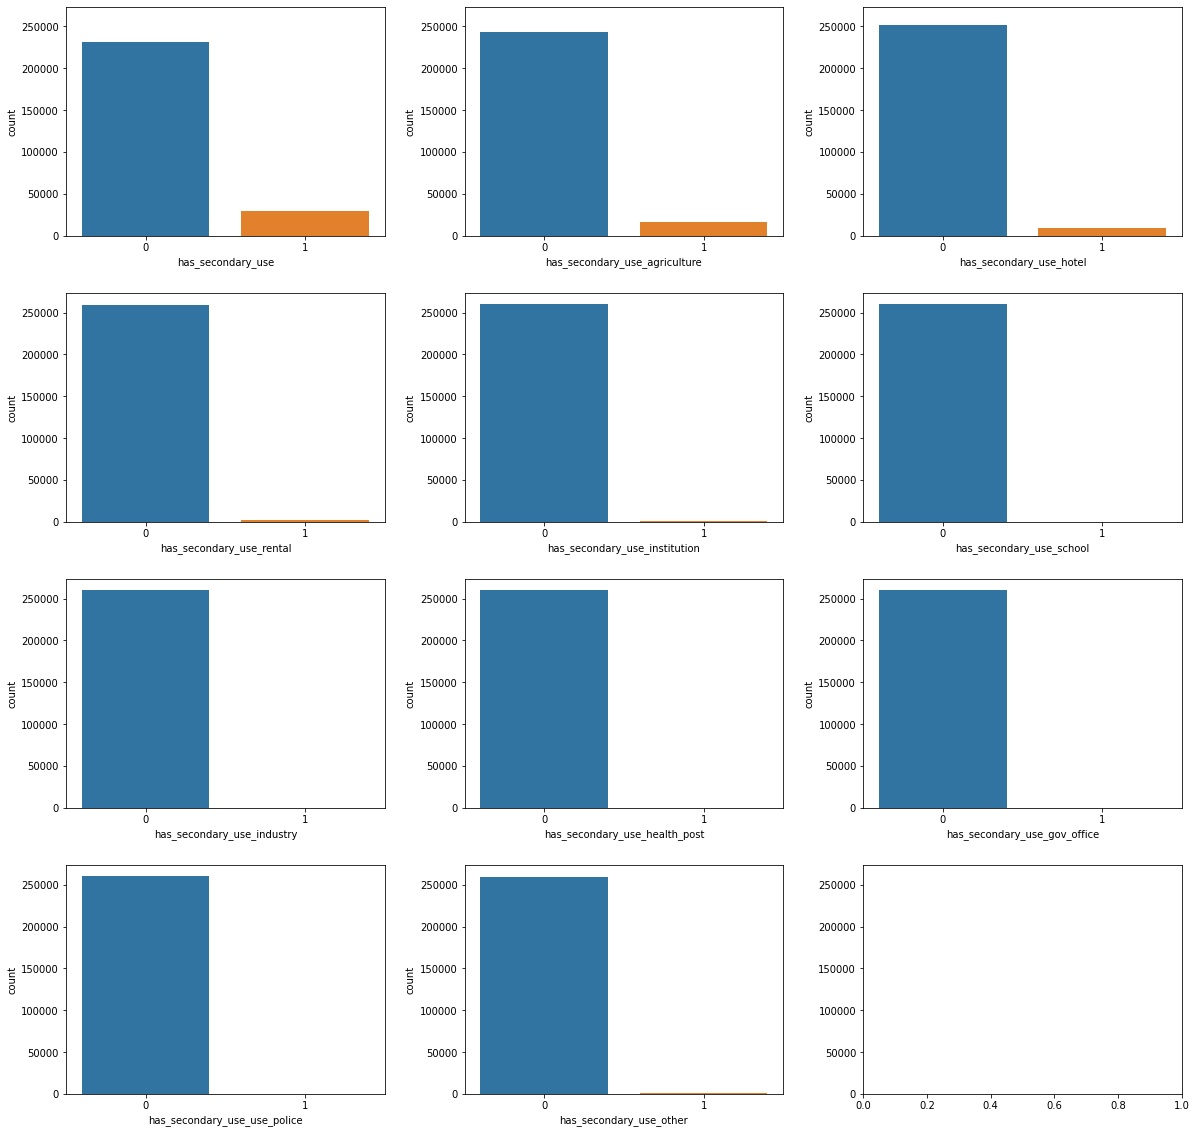

In [ ]:
#secondary use characteristics

fig, axes = plt.subplots(4, 3, figsize=(20, 20))
fig.subplots_adjust(wspace=0.25)
fig.subplots_adjust(hspace=0.25)
sns.countplot(ax=axes[0, 0], data=X, x='has_secondary_use')
sns.countplot(ax=axes[0, 1], data=X, x='has_secondary_use_agriculture')
sns.countplot(ax=axes[0, 2], data=X, x='has_secondary_use_hotel')
sns.countplot(ax=axes[1, 0], data=X, x='has_secondary_use_rental')
sns.countplot(ax=axes[1, 1], data=X, x='has_secondary_use_institution')
sns.countplot(ax=axes[1, 2], data=X, x='has_secondary_use_school')
sns.countplot(ax=axes[2, 0], data=X, x='has_secondary_use_industry')
sns.countplot(ax=axes[2, 1], data=X, x='has_secondary_use_health_post')
sns.countplot(ax=axes[2, 2], data=X, x='has_secondary_use_gov_office')
sns.countplot(ax=axes[3, 0], data=X, x='has_secondary_use_use_police')
sns.countplot(ax=axes[3, 1], data=X, x='has_secondary_use_other')
plt.setp(axes, ylim=axes[3,0].get_ylim());

Now that we have explored the data, let's move into modeling. We know that the categorical features need to be encoded. Our issue here, as discussed in our ReadMe, is that the DrivenData competition has randomly encoded these features. This makes it so we do not know if they are ordinal or generally categorical. This means that we have to encode all categorical features the same way. For our numeric features, we need to scale them to prepare for our classification models. We have completed these transformations below.

In [ ]:
ctr = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore'), ['land_surface_condition', 
                       'foundation_type', 
                       'roof_type', 
                       'ground_floor_type', 
                       'other_floor_type', 
                       'position', 
                       'plan_configuration', 
                       'legal_ownership_status']
     ), remainder = 'passthrough', verbose_feature_names_out = False)
X_train_enc = pd.DataFrame(ctr.fit_transform(X_train), columns = ctr.get_feature_names_out())
X_val_enc = pd.DataFrame(ctr.transform(X_val), columns = ctr.get_feature_names_out())

In [ ]:
cts = make_column_transformer(
    (StandardScaler(), ['age', 'area_percentage', 'height_percentage']),
    remainder = 'passthrough', verbose_feature_names_out=False)
X_train_ss = pd.DataFrame(cts.fit_transform(X_train_enc), columns = cts.get_feature_names_out())
X_val_ss = pd.DataFrame(cts.transform(X_val_enc), columns = cts.get_feature_names_out())

As we began to build and test models, we realized the data needed to be encoded further. The provided dataset already had several encoded features for the superstructure type and geo level id. However, the categorical features (although we didn't know which letter coincided with which category) needed to be encoded. We understand that some of these features may be ordinal, but because the letters were randomly assigned, we had no way of knowing which was which. Therefore, we encoded all categorical columns as numeric dummified columns.


Further, the last few non-binary numeric columns needed to be scaled. We scaled these data points because it allowed us to have a more prepared dataset for classification modeling, especially with models like Random Forest and KNearestNeighbors. These were the only two preprocessing transformers we needed to run. As a reminder, the dataset did not come with any null values, and all dtypes coincided with the feature. 

In [ ]:
# def modeling(mod, model, params):
#     mod = model
#     gs = GridSearchCV(mod, params, n_jobs=-1)
#     gs.fit(X_train_ss, y_train)
#     print('X train Accuracy: ', accuracy_score(y_train, gs.predict(X_train_ss))),
#     print('X test Accuracy: ', accuracy_score(y_val, gs.predict(X_val_ss))),
#     print('X train F1: ', f1_score(y_train, gs.predict(X_train_ss), average='weighted')), 
#     print('X test F1: ', f1_score(y_val, gs.predict(X_val_ss), average='weighted'))

    # lg_params = {
#     'tol': [.0001, .001, .01, .1],
#     'C': [.01, .1, 1, 10, 100]
# }

# modeling('lg', LogisticRegression(max_iter=10_000), lg_params)

# svc_params = {
#     'C': [.01, .1, 1, 10, 100],
#     'tol': [.0001, .001, .01, .1],
#     'class_weight': ['balanced', None]
# }

# modeling('svm', SVC(), svc_params)

# gbc_params = {
#     'loss': ['deviance'],
#     'n_estimators': [5, 10, 50, 100, 250],
#     'min_samples_split': [2, 5, 7]
# }

# modeling('gbc', GradientBoostingClassifier(), gbc_params)

# rfr_params = {
#     'n_estimators' : [10, 50, 100, 150],
#     'max_depth' : [3, 4, 5]
# }

# modeling('rfr', RandomForestClassifier(), rfr_params)

# dtr_params = {
#     'criterion' : ['gini', 'entropy'],
#     'max_depth' : [3, 4, 5]
# }

# modeling('dtr', DecisionTreeClassifier(), dtr_params)

# knn_params = {
#     'n_neighbors' : [2, 4, 6, 8],
#     'weights' : ['uniform', 'distance']
# }

# modeling('knn', KNeighborsClassifier(), knn_params)

To build out our models, we wanted a way to simplify the amount of code we wrote while still testing several models. Because the process is the same for each model, we wrote a function to fit and score the dataset on the given model. This worked well especially when working with the smaller datasets as it made for quick decisions of our best model.

When testing our smaller data set, the KNearestNeighbors and GradientBoost models were the best performers with the highest accuracy scores, 0.99 and 0.79 respectively. Because of this, we ran our large dataset on only these two models. This saved us time as opposed to waiting for the other models to run through hundreds of thousands of data points. Even though we decided to forego using the other models on our large dataset, we included the code here to show the hyperparameter tuning and consideration that took place while testing models. Because we were able to run these models on a smaller dataset using this function, we will use them outside of this function in order to have the ability to use the model results (predictions, etc). 

In [ ]:
knn_params = {
    'n_neighbors' : [2, 4, 6, 8],
    'weights' : ['uniform', 'distance']
}

knn = KNeighborsClassifier()
gs = GridSearchCV(knn, knn_params, n_jobs=-1)
gs.fit(X_train_ss, y_train)
print('X train Accuracy: ', accuracy_score(y_train, gs.predict(X_train_ss))),
print('X test Accuracy: ', accuracy_score(y_val, gs.predict(X_val_ss))),
print('X train F1: ', f1_score(y_train, gs.predict(X_train_ss), average='weighted')), 
print('X test F1: ', f1_score(y_val, gs.predict(X_val_ss), average='weighted'))

In [ ]:
gbc_params = {
    'loss': ['deviance'],
    'n_estimators': [5, 10, 50, 100, 250],
    'min_samples_split': [2, 5, 7]
}

gbc = GradientBoostingClassifier()
gs2 = GridSearchCV(gbc, gbc_params, n_jobs=-1)
gs2.fit(X_train_ss, y_train)
print('X train Accuracy: ', accuracy_score(y_train, gs2.predict(X_train_ss))),
print('X test Accuracy: ', accuracy_score(y_val, gs2.predict(X_val_ss))),
print('X train F1: ', f1_score(y_train, gs2.predict(X_train_ss), average='weighted')), 
print('X test F1: ', f1_score(y_val, gs2.predict(X_val_ss), average='weighted'))

One of the main issues we have had in this modeling process was Google Colab timing out because of the long run time of these models. This meant that we would lose the model variable by the time the model finished and would not be able to get other information from it. Because of this, we swapped to a Kaggle Notebook to complete some final runs of the data. The code from the Kaggle Notebook that does not appear above is below. 

In [ ]:
gs.best_params_

In [ ]:
knn = KNeighborsClassifier(n_neighbors=8, n_jobs=-1)
knn.fit(X_train_ss, y_train)
print('X train Accuracy: ', accuracy_score(y_train, knn.predict(X_train_ss))),
print('X test Accuracy: ', accuracy_score(y_val, knn.predict(X_val_ss))),
print('X train F1: ', f1_score(y_train, knn.predict(X_train_ss), average='weighted')), 
print('X test F1: ', f1_score(y_val, knn.predict(X_val_ss), average='weighted'))

In [ ]:
ypred = knn.predict(X_val_ss)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

result = confusion_matrix(y_val, ypred)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_val, ypred)
print("Classification Report:",)
print (result1)
result2 = accuracy_score(y_val,ypred)
print("Accuracy:",result2)
# Jack contributed this code from a class example

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(knn, X_val_ss, y_val, cmap='Greens');

In [ ]:
ypred.mean()

In [ ]:
np.unique(ypred, return_counts=True)

In [ ]:
labels['damage_grade'].value_counts()

In [ ]:
labels['damage_grade'].value_counts(normalize=True)

In [ ]:
labels['damage_grade'].mean()

Because our dataset had over 260,000 datapoints, we decided to first work with smaller sample size of 1,000 and 5,000 data points. This allowed us to build and test models succinctly without the lengthy model run times on such a large data set. The models we built on these smaller datasets were Logistic Regression, SVC, Random Forest Classifier, Decision Trees Classifier, GradientBoost Classifier, and KNearestNeighbors Classifier. We chose these as we wanted to test a broad range of classifier model types in order to see which could produce the best F1 score. 
As for our metric, we are choosing the F1 score as the best evaluation metric for our model because it is that balanced score between precision and recall, and it helps explain the relationship around all positive predictions and false negatives. It also is beneficial for us because we have moderately imbalanced data. It is more transparent about model performance, for example, if our model was heavily predicting one class over another. By evaluating the F1 score, we can get a more clear picture of model performance on our data.

So, we found that K Nearest Neighbors Classifier and Gradient Boost Classifier fit best on our sample datasets. Although these models fit well on the training set, we noted overfitting on the sample test sets. However, we decided to move forward with using these models on our big dataset as they showed promise for a larger scale model. 

Our KNN model fit the big dataset well with a 0.71 test F1 score. The GBC fit the big dataset slightly worse with a 0.68 for both train and test F1 scores. Between these and because we chose F1 to be our evaluation metric, our final model choice is KNN. This intuitively makes sense as we can see structures built in clusters like cities and neighborhoods; it makes sense that a model looking around a certain data point would find similarities. While the GradientBoost performed well on the data, the KNN just slightly outperformed and that was the ultimate decider on our final model. While we were mostly focused on the F1 score, I will also note that the accuracy score for our model was 72%. 

Our model also outperformed the baseline model of 56% predicting all medium level damage. While the model still heavily predicted medium level damage, it predicted more accurately at 72% on the test data. One key part of building our model was tuning hyperparameters. We found that using a neighbor count of 8 was the best hyperparameter. Since our dataset was so large at over 260,000 data points, having a larger neighbor count is beneficial to working through the entirety of the data. Finally, even though KNN over fit on the smaller datasets, it did not show major overfitting on the larger dataset. We attributed this to the larger number of datapoints to train on as compared to the smaller dataset.
